<a href="https://colab.research.google.com/github/eukeun/predict-future-sales/blob/master/feature_engineering_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1, perfect features

In [0]:
import numpy as np
import pandas as pd
import re

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
items = pd.read_csv('/content/drive/My Drive/data/items_t.csv')
shops = pd.read_csv('/content/drive/My Drive/data/shops_t.csv')
cats = pd.read_csv('/content/drive/My Drive/data/item_categories_t.csv')
train = pd.read_csv('/content/drive/My Drive/data/sales_train.csv')
test = pd.read_csv('/content/drive/My Drive/data/test.csv').set_index('ID')

In [0]:
sum(train.duplicated()), sum(test.duplicated())

(6, 0)

In [0]:
sum(items.duplicated()), sum(cats.duplicated()), sum(shops.duplicated())

(0, 0, 0)

In [0]:
train[train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [0]:
# 중복 제거
train.drop_duplicates(inplace=True)

In [0]:
sum(train.duplicated())

0

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

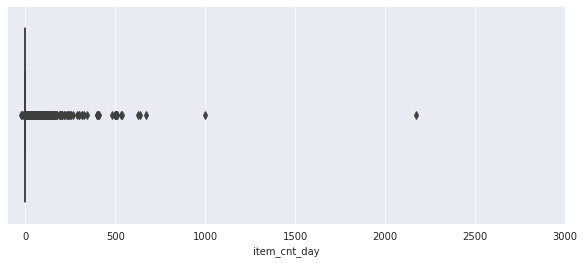

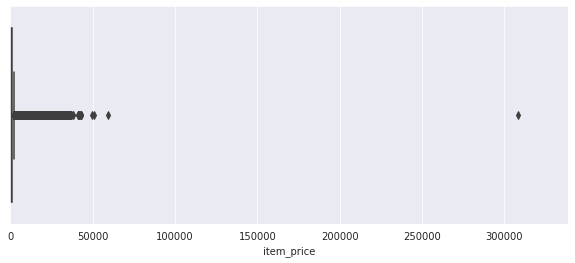

In [0]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [0]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [0]:
train[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


There is one item with price below zero. Fill it with median.

In [0]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [0]:
train.shape

(2935841, 6)

In [0]:
train.drop_duplicates(subset=['date','date_block_num','shop_id','item_id','item_cnt_day'], inplace=True)
train.shape

(2935823, 6)

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [0]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [0]:
items.head()

,item_name,item_id,item_category_id
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


In [0]:
items.head()

,item_name,item_id,item_category_id
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


In [0]:
item_names = items.item_name.values
p = re.compile(r'\((.*?)\)', re.S)
features = []
for o in item_names:
    features.append(re.findall(p, o)[-2:])
features[:5]

[['PLAST'], [], ['UNV'], ['Univ'], ['GLASS']]

In [0]:
item_f1 = []
item_f2 = []

for o in features:
    if len(o) == 0:
        item_f1.append(np.nan)
        item_f2.append(np.nan)
    elif len(o) == 1:
        item_f1.append(o[0])
        item_f2.append(np.nan)
    else:
        item_f1.append(o[1])
        item_f2.append(o[0])

In [0]:
items['item_f1'] = pd.Series(item_f1)
items['item_f2'] = pd.Series(item_f2)
items['item_f1_code'] = LabelEncoder().fit_transform(items['item_f1'].fillna('xxx')).astype(np.int16)
items['item_f2_code'] = LabelEncoder().fit_transform(items['item_f2'].fillna('xxx')).astype(np.int16)

items.drop(['item_f1', 'item_f2'], 1, inplace=True)
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id,item_f1_code,item_f2_code
0,0,40,737,255
1,1,76,1136,255
2,2,40,881,255
3,3,40,886,255
4,4,40,580,255


In [0]:
shops['city_code'] = LabelEncoder().fit_transform(shops['City'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['Type'])
shops = shops[['shop_id','city_code','shop_type_code']]
shops.head()

,shop_id,city_code,shop_type_code
0,0,26,3
1,1,26,4
2,2,0,4
3,3,1,5
4,4,23,4


In [0]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 4 columns):
item_id             22170 non-null int64
item_category_id    22170 non-null int64
item_f1_code        22170 non-null int16
item_f2_code        22170 non-null int16
dtypes: int16(2), int64(2)
memory usage: 433.1 KB


In [0]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

cats.head()

,item_category_id,type_code,subtype_code
0,0,15,32
1,1,0,44
2,2,0,45
3,3,0,46
4,4,0,48


## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [0]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [0]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [0]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [0]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

KeyboardInterrupt: ignored

## Test set
To use time tricks append test pairs to the matrix.

In [0]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [0]:
matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

## Shops/Items/Cats features

In [0]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['shop_type_code'] = matrix['shop_type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

## Traget lags

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [0]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

## Mean encoded features

In [0]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f1_code'], how='left')
matrix['date_cat_item_f1_avg_item_cnt'] = matrix['date_cat_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f1_avg_item_cnt')
matrix.drop(['date_cat_item_f1_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f2_code'], how='left')
matrix['date_cat_item_f2_avg_item_cnt'] = matrix['date_cat_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f2_avg_item_cnt')
matrix.drop(['date_cat_item_f2_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_type_code'], how='left')
matrix['date_item_shop_type_avg_item_cnt'] = matrix['date_item_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_shop_type_avg_item_cnt')
matrix.drop(['date_item_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [0]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [0]:
group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f1_code'], how='left')
matrix['date_subtype_item_f1_avg_item_cnt'] = matrix['date_subtype_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f1_avg_item_cnt')
matrix.drop(['date_subtype_item_f1_avg_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f2_code'], how='left')
matrix['date_subtype_item_f2_avg_item_cnt'] = matrix['date_subtype_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f2_avg_item_cnt')
matrix.drop(['date_subtype_item_f2_avg_item_cnt'], axis=1, inplace=True)

## Trend features

Price trend for the last six months.

In [0]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

Last month shop revenue trend

In [0]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

## Special features

In [0]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [0]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [0]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

In [0]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

Months since the first sale for each shop/item pair and for item only.

In [0]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

Producing lags brings a lot of nulls.

In [0]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [0]:
matrix.columns

Index(['date_block_num', 'item_cnt_month', 'item_id', 'shop_id', 'city_code',
       'shop_type_code', 'item_category_id', 'item_f1_code', 'item_f2_code',
       'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_item_f1_avg_item_cnt_lag_1',
       'date_cat_item_f2_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1_x',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',

In [0]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 49 columns):
date_block_num                             int8
item_cnt_month                             float16
item_id                                    int16
shop_id                                    int8
city_code                                  int8
shop_type_code                             int8
item_category_id                           int8
item_f1_code                               int16
item_f2_code                               int16
type_code                                  int8
subtype_code                               int8
item_cnt_month_lag_1                       float16
item_cnt_month_lag_2                       float16
item_cnt_month_lag_3                       float16
item_cnt_month_lag_6                       float16
item_cnt_month_lag_12                      float16
date_avg_item_cnt_lag_1                    float16
date_item_avg_item_cnt_lag_1               fl

# Part 2, xgboost

In [0]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [0]:
data = pd.read_pickle('/content/drive/My Drive/data/data.pkl')

In [0]:
data = data[data['date_block_num']>11]

In [0]:
data.head()

,date_block_num,item_cnt_month,item_id,shop_id,city_code,shop_type_code,item_category_id,item_f1_code,item_f2_code,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_item_f1_avg_item_cnt_lag_1,date_cat_item_f2_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1_x,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1_y,date_item_city_avg_item_cnt_lag_1,date_item_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,date_subtype_item_f1_avg_item_cnt_lag_1,date_subtype_item_f2_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,0.0,27,2,0,4,19,1136,255,9,45,0.0,0.0,0.0,0.0,1.0,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,1.125000,1.052734,0.955566,0.808594,0.935059,0.148071,0.426514,0.0,0.074097,1.03418,1.075195,1.125977,1.050781,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,0.0,30,2,0,4,40,1136,255,3,23,0.0,0.0,0.0,0.0,0.0,0.411377,1.021484,1.022461,0.521973,0.891113,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.291504,0.398682,0.290771,0.046234,0.051727,0.046234,0.148071,0.426514,0.0,0.962891,0.27002,0.291504,0.398682,0.290771,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,0.0,31,2,0,4,37,390,255,3,9,0.0,0.0,0.0,0.0,0.0,0.411377,0.543457,0.600098,0.543457,0.304443,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.232788,0.227783,0.233276,0.059448,0.051727,0.064697,0.148071,0.426514,0.0,0.555664,0.27002,0.234009,0.227783,0.233887,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,1.0,32,2,0,4,40,1136,255,3,23,0.0,0.0,0.0,0.0,0.0,0.411377,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,0.08905,0.096008,0.141235,0.291504,0.398682,0.290771,0.046234,0.051727,0.046234,0.148071,0.426514,0.0,2.185547,0.27002,0.291504,0.398682,0.290771,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,1.0,33,2,0,4,37,390,255,3,9,1.0,2.0,0.0,0.0,1.0,0.411377,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,0.08905,0.096008,0.141235,0.232788,0.227783,0.233276,0.059448,0.051727,0.064697,0.148071,0.426514,1.0,0.777832,0.27002,0.234009,0.227783,0.233887,-0.225464,1.211914,0,31,1,1,12,12


Select perfect features

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 49 columns):
date_block_num                             int8
item_cnt_month                             float16
item_id                                    int16
shop_id                                    int8
city_code                                  int8
shop_type_code                             int8
item_category_id                           int8
item_f1_code                               int16
item_f2_code                               int16
type_code                                  int8
subtype_code                               int8
item_cnt_month_lag_1                       float16
item_cnt_month_lag_2                       float16
item_cnt_month_lag_3                       float16
item_cnt_month_lag_6                       float16
item_cnt_month_lag_12                      float16
date_avg_item_cnt_lag_1                    float16
date_item_avg_item_cnt_lag_1            

In [0]:
data = data[[
    'date_block_num',
    'item_cnt_month',
    'item_id',                     
    'shop_id',                        
    'city_code',                         
    'shop_type_code',             
    'item_category_id',                         
    'item_f1_code',         
    'item_f2_code',                  
    'type_code',                      
    'subtype_code',                            
    'item_cnt_month_lag_1',                   
    'item_cnt_month_lag_2',            
    'item_cnt_month_lag_3',                  
    'item_cnt_month_lag_6',                  
    'item_cnt_month_lag_12',                
    'date_avg_item_cnt_lag_1',               
    'date_item_avg_item_cnt_lag_1',         
    'date_item_avg_item_cnt_lag_2',         
    'date_item_avg_item_cnt_lag_3',         
    'date_item_avg_item_cnt_lag_6',         
    'date_item_avg_item_cnt_lag_12',       
    'date_shop_avg_item_cnt_lag_1',        
    'date_shop_avg_item_cnt_lag_2',        
    'date_shop_avg_item_cnt_lag_3',        
    'date_shop_avg_item_cnt_lag_6',        
    'date_shop_avg_item_cnt_lag_12',      
    'date_cat_avg_item_cnt_lag_1',          
    'date_cat_item_f1_avg_item_cnt_lag_1', 
    'date_cat_item_f2_avg_item_cnt_lag_1', 
    'date_shop_cat_avg_item_cnt_lag_1',    
    #'date_shop_type_avg_item_cnt_lag_1_x',        
    'date_shop_subtype_avg_item_cnt_lag_1',       
    'date_city_avg_item_cnt_lag_1',               
    #'date_shop_type_avg_item_cnt_lag_1_y',      
    'date_item_city_avg_item_cnt_lag_1',       
    'date_item_shop_type_avg_item_cnt_lag_1',    
    #'date_type_avg_item_cnt_lag_1',         
    #'date_subtype_avg_item_cnt_lag_1',     
    'date_subtype_item_f1_avg_item_cnt_lag_1',
    'date_subtype_item_f2_avg_item_cnt_lag_1',    
    'delta_price_lag',                      
    'delta_revenue_lag_1',                    
    'month',                                    
    'days',                                       
    'item_shop_last_sale',                     
    'item_last_sale',                            
    'item_shop_first_sale',                    
    'item_first_sale',
]]     

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [0]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [0]:
del data
gc.collect();

In [0]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=300,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    sub_sample=0.8,
    eta=0.3,
    seed=42)

model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True,
    early_stopping_rounds=15)


'model = XGBRegressor(\n    max_depth=10,\n    n_estimators=1000,\n    min_child_weight=300,\n    colsample_bytree=0.8,\n    scale_pos_weight=1,\n    sub_sample=0.8,\n    eta=0.3,\n    seed=42)\n\nmodel.fit(\n    X_train,\n    Y_train,\n    eval_metric="rmse",\n    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],\n    verbose=True,\n    early_stopping_rounds=15)\n'

In [0]:
'''depth_list = [9, 10]
colsample_list = [0.5, 0.7, 0.8, 0.9]

val_result_list = []
val_result_list.append(["max_depth", "colsample_bytree", "validation_rmse[0]", "validation_rmse[1]"])

for _max_depth in depth_list:
    for _colsample in colsample_list:
      print("[{0}/{1}] model fitting...".format(_max_depth, _colsample)) 

      model = XGBRegressor(
          max_depth=_max_depth,
          n_estimators=1000,
          min_child_weight=300,
          colsample_bytree=_colsample,
          scale_pos_weight=1,
          sub_sample=0.8,
          eta=0.3,
          seed=42)
      
      model.fit(
          X_train,
          Y_train,
          eval_metric="rmse",
          eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
          verbose=True,
          early_stopping_rounds=50)

      evals_result = model.evals_result()

      val_result_list.append(
          [_max_depth, _colsample, evals_result['validation_1']['rmse'][0], evals_result['validation_1']['rmse'][1]])

      print("[{0}/{1}] : val_rsme_0 = {2}, val_rsme_1 = {3}]".format(
          _max_depth, _colsample, _eta, evals_result['validation_1']['rmse'][0], evals_result['validation_1']['rmse'][1]))

pd.DataFrame(val_result_list).to_csv("validation_result.csv", sep=',', header=None, index=None, encoding='cp949')'''

[9/0.5] model fitting...


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:05:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:02] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12323	validation_1-rmse:1.11652
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.08706	validation_1-rmse:1.08377
[2]	validation_0-rmse:1.06321	validation_1-rmse:1.05724
[3]	validation_0-rmse:1.0182	validation_1-rmse:1.02886
[4]	validation_0-rmse:0.988137	validation_1-rmse:1.00523
[5]	validation_0-rmse:0.967524	validation_1-rmse:0.988991
[6]	validation_0-rmse:0.946512	validation_1-rmse:0.972752
[7]	validation_0-rmse:0.927462	validation_1-rmse:0.960665
[8]	validation_0-rmse:0.912341	validation_1-rm

In [0]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [0]:
plot_features(model, (10,14))

In [0]:
!git clone https://github.com/eukeun/kaggle.git

Cloning into 'kaggle'...
